In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

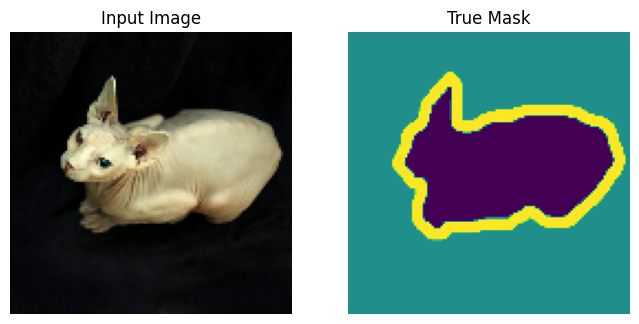

In [5]:
def display(display_list):
    plt.figure(figsize = (8, 8))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train.take(1):
    dis_lst = [image, mask]
display(dis_lst)

In [6]:
OUT_CHANNEL = 3

In [7]:
down_model = tf.keras.applications.MobileNetV2(input_shape = [128, 128, 3], include_top = False)
down_layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project']
down_model_outputs = [down_model.get_layer(name).output for name in down_layer_names]
down_stack = tf.keras.Model(inputs = down_model.input, outputs = down_model_outputs)
down_stack.trainable = False

In [8]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3)
]

In [9]:
def unet_model(out_channels):
    input = tf.keras.layers.Input(shape = [128,128,3])

    skips = down_stack(input)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    out_layer = tf.keras.layers.Conv2DTranspose(
        out_channels, 3, strides = 2, padding = 'same'
    )

    x = out_layer(x)

    return tf.keras.Model(inputs = input, outputs = x)

In [10]:
model = unet_model(OUT_CHANNEL)

In [11]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

1/1 [==============================] - 0s 21ms/step


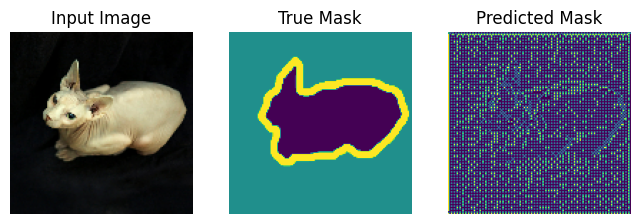

In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        sample_image, sample_mask = dis_lst[0], dis_lst[1]
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
#checking what the untrained model predicts
show_predictions()

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch(self, epoch, logs = None):
        clear_output(wait = True)
        show_predictions()
        print(f'\nPrediction after {epoch+1} epochs')

In [21]:
EPOCHS = 20
VAL_SPLIT = 5
VAL_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SPLIT

In [23]:
history = model.fit(train_dataset, 
                    epochs = EPOCHS,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS, 
                    validation_data = test_dataset, 
                    callbacks = [DisplayCallback()])

Epoch 1/20
57/57 [==============================] - 11s 94ms/step - loss: 0.5188 - accuracy: 0.7863 - val_loss: 0.5232 - val_accuracy: 0.8186
Epoch 2/20
57/57 [==============================] - 6s 77ms/step - loss: 0.3008 - accuracy: 0.8777 - val_loss: 0.3283 - val_accuracy: 0.8732
Epoch 3/20
57/57 [==============================] - 4s 76ms/step - loss: 0.2744 - accuracy: 0.8863 - val_loss: 0.3016 - val_accuracy: 0.8784
Epoch 4/20
57/57 [==============================] - 4s 76ms/step - loss: 0.2620 - accuracy: 0.8906 - val_loss: 0.2945 - val_accuracy: 0.8778
Epoch 5/20
57/57 [==============================] - 4s 76ms/step - loss: 0.2507 - accuracy: 0.8943 - val_loss: 0.2834 - val_accuracy: 0.8840
Epoch 6/20
57/57 [==============================] - 4s 76ms/step - loss: 0.2389 - accuracy: 0.8987 - val_loss: 0.2774 - val_accuracy: 0.8867
Epoch 7/20
57/57 [==============================] - 4s 76ms/step - loss: 0.2354 - accuracy: 0.8996 - val_loss: 0.2776 - val_accuracy: 0.8893
Epoch 8/20
5

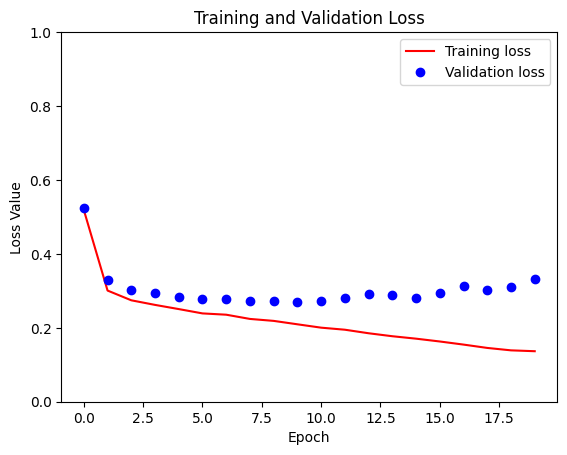

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend()
plt.show()

2/2 [==============================] - 0s 228ms/step


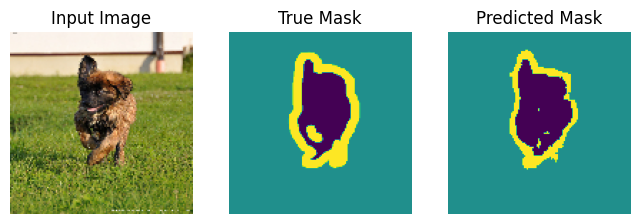

2/2 [==============================] - 0s 18ms/step


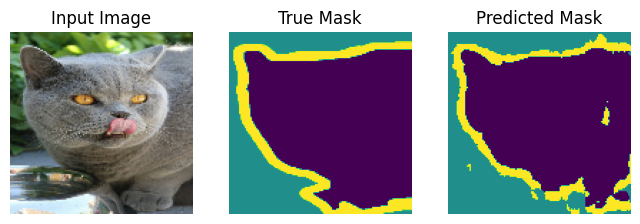

2/2 [==============================] - 0s 20ms/step


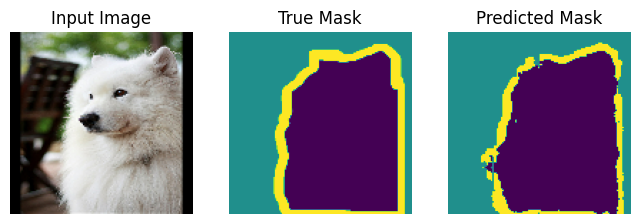

In [26]:
show_predictions(test_dataset, 3)

In [29]:
model_json = model.to_json()

In [30]:
with open('model_json.json','w') as json_file:
    json_file.write(model_json)

In [31]:
model.save_weights('model.h5')